In [1]:
# imports
import pypdb
import math
import numpy
import matplotlib.pyplot as plt
import random
import copy
import pandas as pd
import networkx as nx
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

def degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    return degrees

def rig(matrix, cutoff):
    """
    Input: distance matrix matrix, a cutoff threshold
    Output: RIG model
    """
    n = len(matrix)
    for i in range(n):
        for j in range(n):
            if(i != j):
                if(matrix[i][j] >= cutoff):
                    matrix[i][j] = 0
                else:
                    matrix[i][j] = 1
    return matrix
def lin(matrix, cutoff):
    """
    Input: RIG model adjacency matrix, a cutoff threshold
    Output: LIN model
    """
    n = len(matrix)
    for i in range(n):
        for j in range(n):
            if(matrix[i][j] == 1):
                if(abs(i-j) < cutoff and abs(i-j) > 1):
                    matrix[i][j] = 0
    return matrix

def random1(n,e):
    matrix = [[0 for i in range(n)] for i in range(n)]
    c = 0
    for i in range(n-1):
        matrix[i][i+1]=1
        matrix[i+1][i]=1
        c+=1
    while(c<e):
        a = random.randint(0,n-1)
        b = random.randint(0,n-1)
        if(a==b):
            continue
        if(matrix[a][b]==1):
            continue
        else:
            matrix[a][b]=1
            matrix[b][a]=1
            c+=1
    return matrix
            
def random2(matrix):
    for i in range(500):
        for i in range(len(matrix)):
            a = i
            try:
                b = random.choice([j for j in range(len(matrix[a])) if (matrix[a][j]==1 and abs(a-j)>1)])
            except:
#                 print("b")
                continue
            c = random.randint(0,len(matrix)-1)
            try:
                d = random.choice([j for j in range(len(matrix[c])) if (matrix[c][j]==1 and abs(c-j)>1)])
            except:
#                 print("d")
                continue
            if(matrix[a][c]==0 and matrix[b][d]==0 and matrix[c][a]==0 and matrix[d][b]==0 ):
                if(matrix[a][b] == 0 or matrix[b][a] == 0 or matrix[c][d] == 0 or matrix[d][c] == 0):
                    print("xxx")
                if(a==b or a==c or a==d or b==c or b==d or c==d):
                    continue
                matrix[a][b] = 0
                matrix[b][a] = 0
                matrix[c][d] = 0
                matrix[d][c] = 0

                matrix[a][c] = 1
                matrix[c][a] = 1
                matrix[b][d] = 1
                matrix[d][b] = 1

    return matrix

def bartoli(matrix):
    """
    Input: distance matrix
    Output: random graph based on Bartoli method
    """
    n = len(matrix)
    bartoli = [[0 for i in range(n)] for j in range(n)]
    for i in range(n-2):
        bartoli[i][i+1] = 1
        bartoli[i+1][i] = 1   
        bartoli[i][i+2] = 1
        bartoli[i+2][i] = 1   
    bartoli[n-2][n-1] = 1
    bartoli[n-1][n-2] = 1

    pairs = []
    weights = []
    for i in range(n):
        for j in range(i+1,n):
            pairs.append((i,j))
            weights.append(1/abs(i-j))
            
    for i in range(15):
        r = random.choices(pairs,weights=weights)
        a = r[0][0]
        b = r[0][1]

        for x in range(a-1,a+2):
            for y in range(b-1,b+2):
                if(x<0 or y<0 or x>=n or y>=n):
                    break
                else:
                    bartoli[x][y] = 1
                    bartoli[y][x] = 1
    return bartoli
        
        
        

In [3]:
pdb_list = ["1csp", "1mjc", "1nyf", "1pks", "1shf", "1shg","1ycc", "2pdd", "1aps", "1cis", "1coa", "1fkb", "1hdn", "1pba", "1ubq", "1urn", "1vik",
"2hqi", "2ptl", "2vik", "1aey", "1srl", "1ten", "1tit", "1wit", "2ait", "3mef", "2abd","1hrc", "1imq"]
# pdb_list = ["1csp", "2pdd", "1nyf", "1pks", "1shf","1tit"]
results = {}

for j in range(len(pdb_list)):
    a = pdb_list[j]
    results[a] = {}
    pdb = pypdb.get_pdb_file(a)
    pdb = pdb.split("\n")

    coordinates = []
    ca = []

    for i in pdb:
        if(i[:4]=="ATOM"):
            string = i.split()
            coordinate = []
            coordinate.append(float(string[6]))
            coordinate.append(float(string[7]))
            coordinate.append(float(string[8]))

            if(string[2] == "CA"):
                ca.append(coordinate)
            coordinates.append(coordinate)
        if(i[:6]=="ENDMDL"):
            break
            
#   uncomment to print the coordiantes list
#     for c in coordinates:
#         print(c)
    print(j ,a, len(ca))
    graph = [[0 for i in range(len(ca))] for j in range(len(ca))]
    for i in range(len(ca)):
        for j in range(i+1,len(ca)):
            graph[i][j] = math.sqrt(math.pow(ca[i][0] - ca[j][0], 2) + math.pow(ca[i][1] - ca[j][1], 2) + math.pow(ca[i][2] - ca[j][2], 2))
            graph[j][i] = math.sqrt(math.pow(ca[i][0] - ca[j][0], 2) + math.pow(ca[i][1] - ca[j][1], 2) + math.pow(ca[i][2] - ca[j][2], 2))	
    distmatrix = copy.deepcopy(graph)


    rigmatrix = rig(graph, 7)    
    rigmatrix = numpy.array(rigmatrix)    
    G = nx.Graph(rigmatrix)  
    v = G.number_of_nodes()
    e = G.number_of_edges()
    results[a]["rig_L"] = nx.average_shortest_path_length(G)
    results[a]["rig_C"] = nx.average_clustering(G)
    results[a]["rig_deg_dist"] = degree_dist(G)
    results[a]["rig_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["rig_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)


#  uncomment to create the adjacecncy matrix of RIG  
#     plt.imshow(rigmatrix, cmap='hot', interpolation='nearest')
#     plt.show()

    linmatrix = lin(rigmatrix,12)
    linmatrix = numpy.array(linmatrix)
    G = nx.Graph(linmatrix)
    v_l = G.number_of_nodes()
    e_l = G.number_of_edges()
    n = 0
    s = 0
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        s+=nx.average_shortest_path_length(C)
        n+=1
    results[a]["lin_L"] = s/n
    results[a]["lin_C"] = nx.average_clustering(G)
    results[a]["lin_deg_dist"] = degree_dist(G)
    results[a]["lin_deg_dist_max"] = max(degree_dist(G))
    results[a]["lin_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["lin_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)
    
#  uncomment to create the adjacecncy matrix of LIN    
#     plt.imshow(linmatrix, cmap='hot', interpolation='nearest')
#     plt.show()

    randomgraph1 = random1(v,e)
    randomgraph1 = numpy.array(randomgraph1)
    G = nx.Graph(randomgraph1)  
    results[a]["rig_r1_L"] = nx.average_shortest_path_length(G)
    results[a]["rig_r1_C"] = nx.average_clustering(G)
    results[a]["rig_r1_deg_dist"] = degree_dist(G)
    results[a]["rig_r1_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["rig_r1_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)

    
    randomgraph2 = random2(rigmatrix)
    randomgraph2 = numpy.array(randomgraph2)
    G = nx.Graph(randomgraph2)  
    n = 0
    s = 0
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        s+=nx.average_shortest_path_length(C)
        n+=1
    results[a]["rig_r2_L"] = s/n
    results[a]["rig_r2_C"] = nx.average_clustering(G)
    results[a]["rig_r2_deg_dist"] = degree_dist(G)
    results[a]["rig_r2_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["rig_r2_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)
    
    randomgraph1_l = random1(v_l,e_l)
    randomgraph1_l = numpy.array(randomgraph1_l)
    G = nx.Graph(randomgraph1_l)  
    results[a]["lin_r1_L"] = nx.average_shortest_path_length(G)
    results[a]["lin_r1_C"] = nx.average_clustering(G)
    results[a]["lin_r1_deg_dist"] = degree_dist(G)
    results[a]["lin_r1_deg_dist_max"] = max(degree_dist(G))
    results[a]["lin_r1_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["lin_r1_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)

    
    randomgraph2_l = random2(linmatrix)
    randomgraph2_l = numpy.array(randomgraph2_l)
    G = nx.Graph(randomgraph2_l)  
    n = 0
    s = 0
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        s+=nx.average_shortest_path_length(C)
        n+=1
    results[a]["lin_r2_L"] = s/n
    results[a]["lin_r2_C"] = nx.average_clustering(G)
    results[a]["lin_r2_deg_dist"] = degree_dist(G)
    results[a]["lin_r2_deg_dist_max"] = max(degree_dist(G))
    results[a]["lin_r2_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["lin_r2_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)
     
    bartolimatrix = bartoli(distmatrix)
    bartolimatrix = numpy.array(bartolimatrix)
    G = nx.Graph(bartolimatrix)
    results[a]["bartoli_L"] = s/n
    results[a]["bartoli_C"] = nx.average_clustering(G)
    results[a]["bartoli_deg_dist"] = degree_dist(G)
    results[a]["bartoli_deg_dist_max"] = max(degree_dist(G))
    results[a]["bartoli_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["bartoli_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)
    
    bartolilinmatrix = lin(bartolimatrix,12)
    bartolilin = numpy.array(bartolilinmatrix)
    G = nx.Graph(bartolilinmatrix)
    n = 0
    s = 0
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        s+=nx.average_shortest_path_length(C)
        n+=1
    results[a]["lin_bartoli_L"] = s/n
    results[a]["lin_bartoli_C"] = nx.average_clustering(G)
    results[a]["lin_bartoli_deg_dist"] = degree_dist(G)
    results[a]["lin_bartoli_deg_dist_max"] = max(degree_dist(G))
    results[a]["lin_bartoli_avg_neighbour_degree"] = nx.average_neighbor_degree(G)
    results[a]["lin_bartoli_pearson_correlation"] = nx.degree_pearson_correlation_coefficient(G)
    
    results[a]["lnkf"]=None

    
    


0 1csp 67
1 1mjc 69
2 1nyf 58
3 1pks 76
4 1shf 118
5 1shg 57
6 1ycc 107
7 2pdd 43
8 1aps 98
9 1cis 66
10 1coa 64
11 1fkb 107
12 1hdn 85
13 1pba 81
14 1ubq 76
15 1urn 288
16 1vik 198
17 2hqi 72
18 2ptl 78
19 2vik 126
20 1aey 58
21 1srl 56
22 1ten 89
23 1tit 89
24 1wit 93
25 2ait 74
26 3mef 69
27 2abd 86
28 1hrc 104
29 1imq 86


In [5]:
df = pd.DataFrame(results)
df["1hrc"]["lnkf"] = 8.76
df["1imq"]["lnkf"] = 7.31
df["1ycc"]["lnkf"] = 9.62
df["2abd"]["lnkf"] = 6.55
df["2pdd"]["lnkf"] = 9.8
df["1aps"]["lnkf"] = -1.48
df["1cis"]["lnkf"] = 3.87
df["1coa"]["lnkf"] = 3.87
df["1fkb"]["lnkf"] = 1.46
df["1hdn"]["lnkf"] = 2.7
df["1pba"]["lnkf"] = 6.8
df["1ubq"]["lnkf"] = 7.33
df["1urn"]["lnkf"] = 5.76
df["1vik"]["lnkf"] = 6.8
df["2hqi"]["lnkf"] = 0.18
df["2ptl"]["lnkf"] = 4.1
df["2vik"]["lnkf"] = 6.8
df["1aey"]["lnkf"] = 2.09
df["1csp"]["lnkf"] = 6.98
df["1mjc"]["lnkf"] = 5.24
df["1nyf"]["lnkf"] = 4.54
df["1pks"]["lnkf"] = -1.05
df["1shf"]["lnkf"] = 4.55
df["1shg"]["lnkf"] = 1.41
df["1srl"]["lnkf"] = 4.04
df["1ten"]["lnkf"] = 1.06
df["1tit"]["lnkf"] = 3.47
df["1wit"]["lnkf"] = 0.41
df["2ait"]["lnkf"] = 4.2
df["3mef"]["lnkf"] = 5.3
df = df.transpose()
df.to_csv("all_data.csv")

In [2]:
# df = pd.read_csv("all_data.csv" , index_col=0)
# df

,rig_L,rig_C,rig_deg_dist,rig_avg_neighbour_degree,rig_pearson_correlation,lin_L,lin_C,lin_deg_dist,lin_deg_dist_max,lin_avg_neighbour_degree,...,bartoli_deg_dist_max,bartoli_avg_neighbour_degree,bartoli_pearson_correlation,lin_bartoli_L,lin_bartoli_C,lin_bartoli_deg_dist,lin_bartoli_deg_dist_max,lin_bartoli_avg_neighbour_degree,lin_bartoli_pearson_correlation,lnkf
1csp,3.044776,0.561993,"[5, 6, 7, 10, 10, 13, 9, 8, 11, 8, 6, 4, 5, 8,...","{0: 8.6, 1: 8.666666666666666, 2: 9.2857142857...",0.346111,4.612393,0.326143,"[4, 5, 6, 8, 9, 9, 5, 4, 5, 2, 3, 2, 2, 5, 5, ...",10,"{0: 7.25, 1: 6.8, 2: 7.833333333333333, 3: 7.3...",...,15,"{0: 3.5, 1: 3.3333333333333335, 2: 4.75, 3: 7....",0.446882,11.615559,0.149254,"[1, 2, 2, 2, 2, 4, 4, 5, 5, 5, 2, 2, 2, 5, 5, ...",5,"{0: 2.0, 1: 1.5, 2: 2.0, 3: 2.0, 4: 3.0, 5: 2....",0.740038,6.98
1mjc,3.075874,0.560629,"[2, 4, 7, 8, 8, 11, 10, 12, 8, 7, 9, 8, 7, 4, ...","{0: 5.5, 1: 6.5, 2: 7.571428571428571, 3: 9.0,...",0.371268,4.700767,0.321889,"[1, 3, 5, 6, 7, 9, 9, 9, 5, 3, 5, 2, 3, 2, 2, ...",10,"{0: 3.0, 1: 4.0, 2: 6.8, 3: 7.166666666666667,...",...,16,"{0: 7.5, 1: 8.166666666666666, 2: 7.7777777777...",0.239467,5.533674,0.260732,"[1, 2, 2, 2, 2, 5, 8, 8, 5, 2, 2, 2, 2, 5, 5, ...",10,"{0: 2.0, 1: 1.5, 2: 2.0, 3: 2.0, 4: 3.5, 5: 6....",0.506047,5.24
1nyf,2.843920,0.579800,"[2, 6, 10, 12, 12, 13, 7, 7, 7, 7, 6, 7, 4, 5,...","{0: 8.0, 1: 8.5, 2: 8.4, 3: 9.0, 4: 8.58333333...",0.229746,4.457350,0.327942,"[1, 5, 8, 10, 10, 10, 6, 5, 4, 2, 2, 2, 2, 2, ...",10,"{0: 5.0, 1: 5.8, 2: 7.0, 3: 7.0, 4: 6.7, 5: 6....",...,14,"{0: 7.125, 1: 7.125, 2: 6.8, 3: 6.8, 4: 6.1666...",0.329394,7.753781,0.149918,"[4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 2, 4, ...",8,"{0: 5.25, 1: 4.4, 2: 3.5, 3: 2.0, 4: 2.0, 5: 2...",0.626781,4.54
1pks,3.080702,0.557454,"[3, 8, 11, 11, 12, 11, 14, 7, 8, 8, 7, 7, 7, 5...","{0: 7.333333333333333, 1: 8.75, 2: 9.090909090...",0.231951,4.388772,0.332002,"[3, 7, 10, 10, 10, 10, 11, 6, 6, 5, 2, 2, 2, 2...",11,"{0: 5.666666666666667, 1: 6.428571428571429, 2...",...,16,"{0: 6.4, 1: 5.833333333333333, 2: 5.8333333333...",0.423413,8.951930,0.115476,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, ...",9,"{0: 2.0, 1: 1.5, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2....",0.714444,-1.05
1shf,4.635666,0.563790,"[3, 5, 9, 11, 12, 12, 8, 7, 6, 7, 6, 7, 4, 5, ...","{0: 8.333333333333334, 1: 8.2, 2: 8.4444444444...",0.275412,6.456178,0.337362,"[2, 4, 7, 9, 10, 10, 7, 5, 4, 2, 2, 2, 2, 2, 2...",10,"{0: 7.0, 1: 6.25, 2: 7.428571428571429, 3: 7.5...",...,12,"{0: 6.8, 1: 6.666666666666667, 2: 6.75, 3: 6.8...",0.403466,12.058960,0.151049,"[4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, ...",8,"{0: 4.25, 1: 3.6, 2: 3.5, 3: 2.0, 4: 2.0, 5: 2...",0.715038,4.55
1shg,2.794486,0.564797,"[4, 6, 10, 12, 12, 12, 8, 7, 6, 7, 7, 7, 4, 5,...","{0: 9.25, 1: 8.333333333333334, 2: 8.6, 3: 9.0...",0.199538,4.426065,0.339933,"[3, 5, 8, 10, 10, 10, 7, 5, 4, 2, 2, 2, 2, 2, ...",10,"{0: 6.666666666666667, 1: 5.6, 2: 6.75, 3: 6.9...",...,12,"{0: 3.5, 1: 5.333333333333333, 2: 6.25, 3: 7.5...",0.449995,11.491855,0.112281,"[1, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2, 4, 5, 2, 2, ...",6,"{0: 2.0, 1: 1.5, 2: 3.5, 3: 4.4, 4: 5.0, 5: 4....",0.627978,1.41
1ycc,4.017281,0.561965,"[2, 4, 6, 5, 7, 7, 8, 10, 7, 8, 13, 10, 8, 9, ...","{0: 5.0, 1: 5.25, 2: 6.333333333333333, 3: 7.2...",0.289181,6.984306,0.250134,"[1, 3, 4, 3, 5, 5, 4, 6, 3, 3, 7, 4, 2, 3, 3, ...",8,"{0: 3.0, 1: 3.0, 2: 4.0, 3: 5.0, 4: 5.8, 5: 6....",...,12,"{0: 9.0, 1: 8.875, 2: 8.875, 3: 8.4, 4: 8.3333...",0.570329,16.480691,0.128571,"[1, 2, 2, 2, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2, 2, ...",8,"{0: 2.0, 1: 1.5, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3....",0.713405,9.62
2pdd,2.727575,0.624887,"[3, 5, 9, 6, 6, 6, 9, 8, 8, 8, 12, 8, 6, 6, 6,...","{0: 6.666666666666667, 1: 6.2, 2: 6.6666666666...",0.097938,5.495017,0.105426,"[2, 4, 6, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, ...",6,"{0: 4.5, 1: 4.25, 2: 3.5, 3: 4.0, 4: 2.0, 5: 2...",...,13,"{0: 7.6, 1: 6.833333333333333, 2: 6.2857142857...",0.521882,14.666667,0.000000,"[1, 2, 2, 

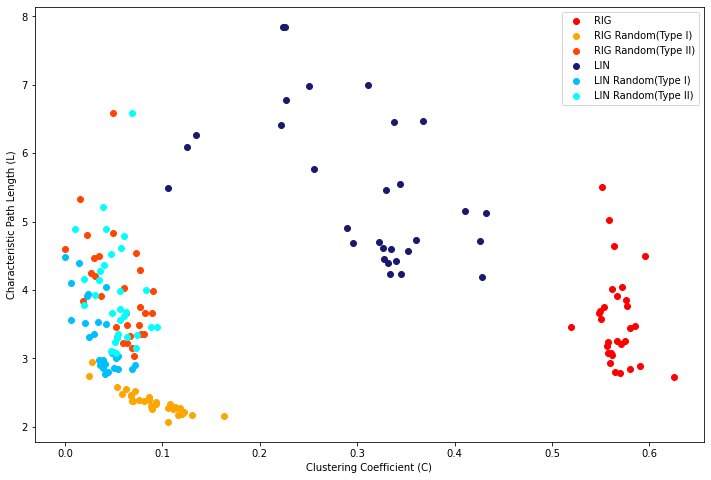

In [7]:
x = df["rig_C"]
y = df["rig_L"]
plt.scatter(x,y, color="red",label="RIG")
x = df["rig_r1_C"]
y = df["rig_r1_L"]
plt.scatter(x,y, color="orange", label="RIG Random(Type I)")
x = df["rig_r2_C"]
y = df["rig_r2_L"]
plt.scatter(x,y, color="orangered", label="RIG Random(Type II)")

x = df["lin_C"]
y = df["lin_L"]
plt.scatter(x,y, color="midnightblue",label="LIN")
x = df["lin_r1_C"]
y = df["lin_r1_L"]
plt.scatter(x,y, color="deepskyblue", label="LIN Random(Type I)")
x = df["lin_r2_C"]
y = df["lin_r2_L"]
plt.scatter(x,y, color="cyan", label="LIN Random(Type II)")
plt.xlabel("Clustering Coefficient (C)")
plt.ylabel("Characteristic Path Length (L)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LvsC')
plt.show()


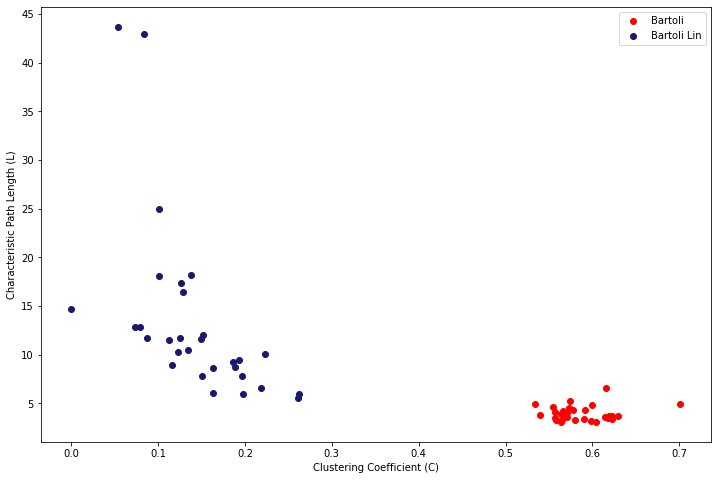

In [9]:
x = df["bartoli_C"]
y = df["bartoli_L"]
plt.scatter(x,y, color="red",label="Bartoli")

x = df["lin_bartoli_C"]
y = df["lin_bartoli_L"]
plt.scatter(x,y, color="midnightblue",label="Bartoli Lin")

plt.xlabel("Clustering Coefficient (C)")
plt.ylabel("Characteristic Path Length (L)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LvsCBartoli')
plt.show()

# Normalized Degree Distribution

In [17]:
degree_distributions_rig = []
degree_distributions_lin = []
degree_distributions_lin_r1 = []
degree_distributions_bartoli_rig = []
degree_distributions_bartoli_lin = []

for i in range(len(df)):
    degree_distributions_rig.append(np.histogram(df["rig_deg_dist"][i], bins = np.arange(0, np.array(df["rig_deg_dist"][i]).max()+2)-0.5)[0])
    degree_distributions_lin.append(np.histogram(df["lin_deg_dist"][i], bins = np.arange(0, np.array(df["lin_deg_dist"][i]).max()+2)-0.5)[0])
    degree_distributions_bartoli_rig.append(np.histogram(df["bartoli_deg_dist"][i], bins = np.arange(0, np.array(df["bartoli_deg_dist"][i]).max()+2)-0.5)[0])
    degree_distributions_bartoli_lin.append(np.histogram(df["lin_bartoli_deg_dist"][i], bins = np.arange(0, np.array(df["lin_bartoli_deg_dist"][i]).max()+2)-0.5)[0])
    degree_distributions_lin_r1.append(np.histogram(df["lin_r1_deg_dist"][i], bins = np.arange(0, np.array(df["lin_r1_deg_dist"][i]).max()+2)-0.5)[0])
    
degree_distributions_rig = np.array(degree_distributions_rig)
degree_distributions_lin = np.array(degree_distributions_lin)
degree_distributions_bartoli_rig = np.array(degree_distributions_bartoli_rig)
degree_distributions_bartoli_lin = np.array(degree_distributions_bartoli_lin)
degree_distributions_lin_r1 = np.array(degree_distributions_lin_r1)

In [18]:
degree_distributions_rig = pad_sequences(degree_distributions_rig, padding = 'post')
degree_distributions_lin = pad_sequences(degree_distributions_lin, padding = 'post')
degree_distributions_bartoli_rig = pad_sequences(degree_distributions_bartoli_rig, padding = 'post')
degree_distributions_bartoli_lin = pad_sequences(degree_distributions_bartoli_lin, padding = 'post')
degree_distributions_lin_r1 = pad_sequences(degree_distributions_lin_r1, padding = 'post')

In [21]:
normalized_rig= []
normalized_lin = []
normalized_lin_r1 = []
normalized_bartoli = []
normalized_bartoli_lin = []

for i in range(len(degree_distributions_rig)):
    x = degree_distributions_rig[i,:].max()
    normalized_rig.append(degree_distributions_rig[i,:]/x)
    
for i in range(len(degree_distributions_lin)):
    x = degree_distributions_lin[i,:].max()
    normalized_lin.append(degree_distributions_lin[i,:]/x)
    
for i in range(len(degree_distributions_bartoli_rig)):
    x = degree_distributions_bartoli_rig[i,:].max()
    normalized_bartoli.append(degree_distributions_bartoli_rig[i,:]/x)
    
for i in range(len(degree_distributions_bartoli_lin)):
    x = degree_distributions_bartoli_lin[i,:].max()
    normalized_bartoli_lin.append(degree_distributions_bartoli_lin[i,:]/x)
    
for i in range(len(degree_distributions_lin_r1)):
    x = degree_distributions_lin_r1[i,:].max()
    normalized_lin_r1.append(degree_distributions_lin_r1[i,:]/x)
normalized_rig = np.array(normalized_rig)
normalized_lin = np.array(normalized_lin)
normalized_bartoli = np.array(normalized_bartoli)
normalized_bartoli_lin = np.array(normalized_bartoli_lin)
normalized_lin_r1 = np.array(normalized_lin_r1)

In [26]:
normalized_rig_mean = []
normalized_rig_sd = []
normalized_lin_mean = []
normalized_lin_sd = []
normalized_bartoli_mean = []
normalized_bartoli_sd = []
normalized_bartoli_lin_mean = []
normalized_bartoli_lin_sd = []
normalized_lin_r1_mean = []
normalized_lin_r1_sd = []

for i in range(len(degree_distributions_rig[0])):
    x = degree_distributions_rig[:,i].max()
    if(x == 0):
        normalized_rig_mean.append((degree_distributions_rig[:,i]).mean())
        normalized_rig_sd.append(degree_distributions_rig[:,i].std())
    else:
        normalized_rig_mean.append((degree_distributions_rig[:,i]).mean())
        normalized_rig_sd.append((degree_distributions_rig[:,i]).std())
        
for i in range(len(degree_distributions_lin[0])):
    x = degree_distributions_lin[:,i].max()
    if(degree_distributions_lin[:,i].max() == 0):
        normalized_lin_mean.append((degree_distributions_lin[:,i]).mean())
        normalized_lin_sd.append(degree_distributions_lin[:,i].std())
    else:
        normalized_lin_mean.append((degree_distributions_lin[:,i]).mean())
        normalized_lin_sd.append((degree_distributions_lin[:,i]).std())
        
for i in range(len(degree_distributions_bartoli_rig[0])):
    x = degree_distributions_bartoli_rig[:,i].max()
    if(x == 0):
        normalized_bartoli_mean.append((degree_distributions_bartoli_rig[:,i]).mean())
        normalized_bartoli_sd.append(degree_distributions_bartoli_rig[:,i].std())
    else:
        normalized_bartoli_mean.append((degree_distributions_bartoli_rig[:,i]).mean())
        normalized_bartoli_sd.append((degree_distributions_bartoli_rig[:,i]).std())
        
for i in range(len(degree_distributions_bartoli_lin[0])):
    x = degree_distributions_bartoli_lin[:,i].max()
    if(x == 0):
        normalized_bartoli_lin_mean.append((degree_distributions_bartoli_lin[:,i]).mean())
        normalized_bartoli_lin_sd.append(degree_distributions_bartoli_lin[:,i].std())
    else:
        normalized_bartoli_lin_mean.append((degree_distributions_bartoli_lin[:,i]).mean())
        normalized_bartoli_lin_sd.append((degree_distributions_bartoli_lin[:,i]).std())
        
for i in range(len(degree_distributions_lin_r1[0])):    
    x = degree_distributions_lin_r1[:,i].max()
    if(x == 0):
        normalized_lin_r1_mean.append((degree_distributions_lin_r1[:,i]).mean())
        normalized_lin_r1_sd.append(degree_distributions_lin_r1[:,i].std())
    else:
        normalized_lin_r1_mean.append((degree_distributions_lin_r1[:,i]).mean())
        normalized_lin_r1_sd.append((degree_distributions_lin_r1[:,i]).std())

    

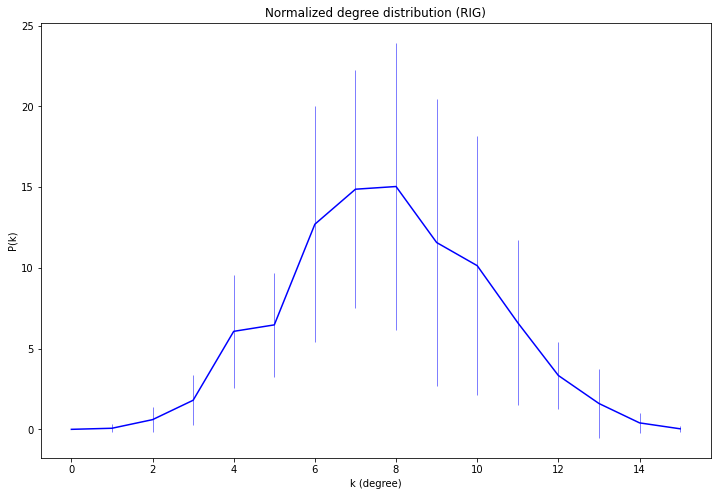

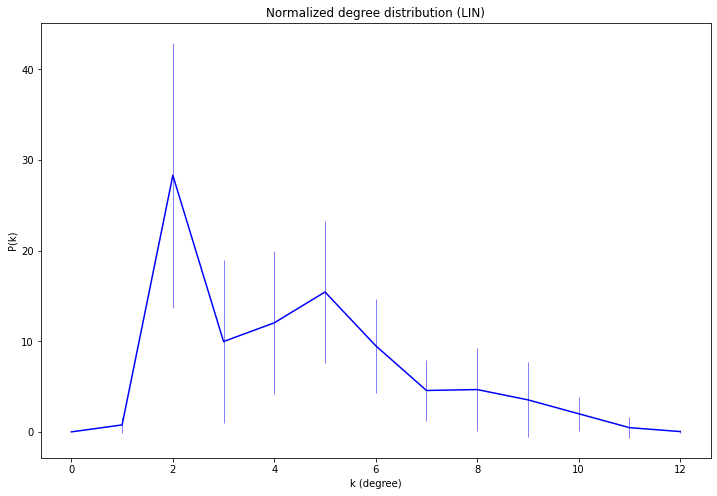

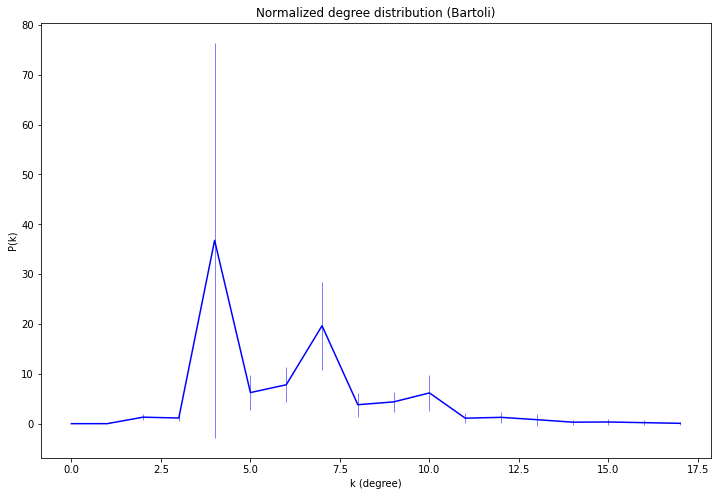

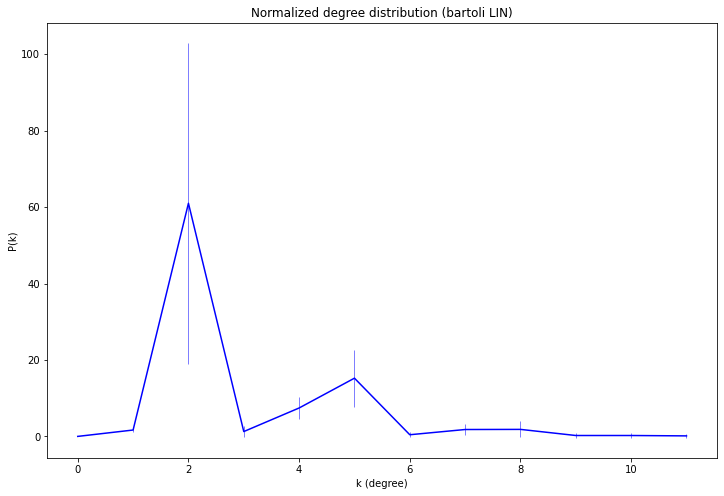

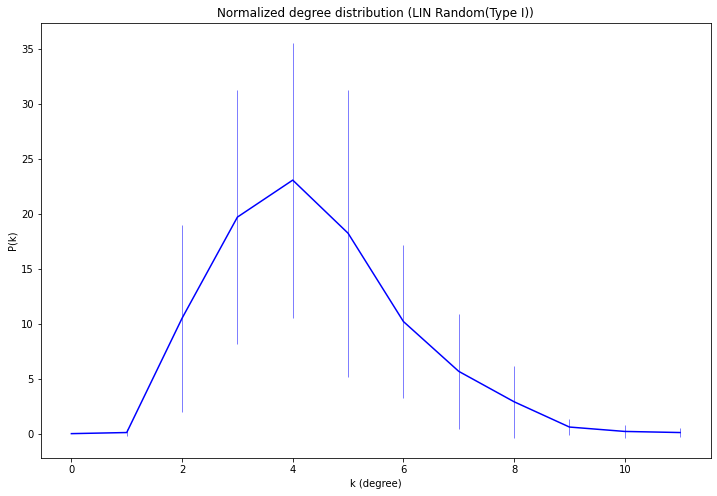

In [27]:
plt.errorbar(y = normalized_rig_mean, x = np.arange(len(normalized_rig_mean)), yerr=normalized_rig_sd, color="blue", elinewidth=0.5)
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Normalized degree distribution (RIG)")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/RIG_deg_dist')
plt.show()


plt.errorbar(y = normalized_lin_mean, x = np.arange(len(normalized_lin_mean)), yerr=normalized_lin_sd, color="blue", elinewidth=0.5)
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Normalized degree distribution (LIN)")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LIN_deg_dist')
plt.show()


plt.errorbar(y = normalized_bartoli_mean, x = np.arange(len(normalized_bartoli_mean)), yerr=normalized_bartoli_sd, color="blue", elinewidth=0.5)
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Normalized degree distribution (Bartoli)")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/bartoli_deg_dist')
plt.show()


plt.errorbar(y = normalized_bartoli_lin_mean, x = np.arange(len(normalized_bartoli_lin_mean)), yerr=normalized_bartoli_lin_sd, color="blue", elinewidth=0.5)
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Normalized degree distribution (bartoli LIN)")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/bartoli_LIN_deg_dist')
plt.show()


plt.errorbar(y = normalized_lin_r1_mean, x = np.arange(len(normalized_lin_r1_mean)), yerr=normalized_lin_r1_sd,color="blue", elinewidth=0.5)
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Normalized degree distribution (LIN Random(Type I))")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LIN_r1_deg_dist')
plt.show()

# Degree vs Neighbour degree

In [29]:
# degree vs neighbour degree
rig_kvsknn = {}
rig_r1_kvsknn = {}
rig_r2_kvsknn = {}
lin_kvsknn = {}
lin_r1_kvsknn = {}
lin_r2_kvsknn = {}
bartoli_kvsknn = {}
lin_bartoli_kvsknn = {}

for j in range(1):
    for i in range(len(df["rig_deg_dist"][j])):
        if(df["rig_deg_dist"][j][i] in rig_kvsknn):
            rig_kvsknn[df["rig_deg_dist"][j][i]].append(df["rig_avg_neighbour_degree"][j][i])
        else:
            rig_kvsknn[df["rig_deg_dist"][j][i]] =[df["rig_avg_neighbour_degree"][j][i]]
            
            
    for i in range(len(df["bartoli_deg_dist"][j])):
        if(df["bartoli_deg_dist"][j][i] in bartoli_kvsknn):
            bartoli_kvsknn[df["bartoli_deg_dist"][j][i]].append(df["bartoli_avg_neighbour_degree"][j][i])
        else:
            bartoli_kvsknn[df["bartoli_deg_dist"][j][i]] =[df["bartoli_avg_neighbour_degree"][j][i]]
            
    for i in range(len(df["lin_bartoli_deg_dist"][j])):
        if(df["lin_bartoli_deg_dist"][j][i] in lin_bartoli_kvsknn):
            lin_bartoli_kvsknn[df["lin_bartoli_deg_dist"][j][i]].append(df["lin_bartoli_deg_dist"][j][i])
        else:
            lin_bartoli_kvsknn[df["lin_bartoli_deg_dist"][j][i]] =[df["lin_bartoli_deg_dist"][j][i]]
            
            
    for i in range(len(df["rig_r1_deg_dist"][j])):
        if(df["rig_r1_deg_dist"][j][i] in rig_r1_kvsknn):
            rig_r1_kvsknn[df["rig_r1_deg_dist"][j][i]].append(df["rig_r1_avg_neighbour_degree"][j][i])
        else:
            rig_r1_kvsknn[df["rig_r1_deg_dist"][j][i]] =[df["rig_r1_avg_neighbour_degree"][j][i]]
            
    for i in range(len(df["rig_r2_deg_dist"][j])):
        if(df["rig_r2_deg_dist"][j][i] in rig_r2_kvsknn):
            rig_r2_kvsknn[df["rig_r2_deg_dist"][j][i]].append(df["rig_r2_avg_neighbour_degree"][j][i])
        else:
            rig_r2_kvsknn[df["rig_r2_deg_dist"][j][i]] =[df["rig_r2_avg_neighbour_degree"][j][i]]
            
    for i in range(len(df["lin_deg_dist"][j])):
        if(df["lin_deg_dist"][j][i] in lin_kvsknn):
            lin_kvsknn[df["lin_deg_dist"][j][i]].append(df["lin_avg_neighbour_degree"][j][i])
        else:
            lin_kvsknn[df["lin_deg_dist"][j][i]] =[df["lin_avg_neighbour_degree"][j][i]]
            
    for i in range(len(df["lin_r1_deg_dist"][j])):
        if(df["lin_r1_deg_dist"][j][i] in lin_r1_kvsknn):
            lin_r1_kvsknn[df["lin_r1_deg_dist"][j][i]].append(df["lin_r1_avg_neighbour_degree"][j][i])
        else:
            lin_r1_kvsknn[df["lin_r1_deg_dist"][j][i]] =[df["lin_r1_avg_neighbour_degree"][j][i]]
            
    for i in range(len(df["lin_r2_deg_dist"][j])):
        if(df["lin_r2_deg_dist"][j][i] in lin_r2_kvsknn):
            lin_r2_kvsknn[df["lin_r2_deg_dist"][j][i]].append(df["lin_r2_avg_neighbour_degree"][j][i])
        else:
            lin_r2_kvsknn[df["lin_r2_deg_dist"][j][i]] =[df["lin_r2_avg_neighbour_degree"][j][i]]
            



In [30]:
for i in rig_kvsknn:
    a = np.array(rig_kvsknn[i])   
    rig_kvsknn[i] = (a.mean(),a.std())

for i in bartoli_kvsknn:
    a = np.array(bartoli_kvsknn[i])   
    bartoli_kvsknn[i] = (a.mean(),a.std())
for i in lin_bartoli_kvsknn:
    a = np.array(lin_bartoli_kvsknn[i])   
    lin_bartoli_kvsknn[i] = (a.mean(),a.std())
    
for i in lin_kvsknn:
    a = np.array(lin_kvsknn[i])   
    lin_kvsknn[i] = (a.mean(),a.std())
    
for i in rig_r1_kvsknn:
    a = np.array(rig_r1_kvsknn[i])   
    rig_r1_kvsknn[i] = (a.mean(),a.std())
    
for i in rig_r2_kvsknn:
    a = np.array(rig_r2_kvsknn[i])   
    rig_r2_kvsknn[i] = (a.mean(),a.std())  
    
for i in lin_r1_kvsknn:
    a = np.array(lin_r1_kvsknn[i])   
    lin_r1_kvsknn[i] = (a.mean(),a.std())
     
for i in lin_r2_kvsknn:
    a = np.array(lin_r2_kvsknn[i])   
    lin_r2_kvsknn[i] = (a.mean(),a.std())

In [33]:
n_rig_kvsknn = []
n_bartoli_kvsknn = []
n_bartoli_lin_kvsknn = []
n_rig_r1_kvsknn = []
n_rig_r2_kvsknn = []
n_lin_kvsknn = []
n_lin_r1_kvsknn = []
n_lin_r2_kvsknn = []

ns_rig_kvsknn = []
ns_bartoli_kvsknn = []
ns_bartoli_lin_kvsknn = []
ns_rig_r1_kvsknn = []
ns_rig_r2_kvsknn = []
ns_lin_kvsknn = []
ns_lin_r1_kvsknn = []
ns_lin_r2_kvsknn = []

for i in range(max(rig_kvsknn)):
    if(i not in rig_kvsknn):
        n_rig_kvsknn.append(0)
        ns_rig_kvsknn.append(0)
    else:
        n_rig_kvsknn.append(rig_kvsknn[i][0])
        ns_rig_kvsknn.append(rig_kvsknn[i][1])
        
for i in range(max(bartoli_kvsknn)):
    if(i not in bartoli_kvsknn):
        n_bartoli_kvsknn.append(0)
        ns_bartoli_kvsknn.append(0)
    else:
        n_bartoli_kvsknn.append(bartoli_kvsknn[i][0])
        ns_bartoli_kvsknn.append(bartoli_kvsknn[i][1])
        
for i in range(max(lin_bartoli_kvsknn)):
    if(i not in lin_bartoli_kvsknn):
        n_bartoli_lin_kvsknn.append(0)
        ns_bartoli_lin_kvsknn.append(0)
    else:
        n_bartoli_lin_kvsknn.append(lin_bartoli_kvsknn[i][0])
        ns_bartoli_lin_kvsknn.append(lin_bartoli_kvsknn[i][1])

for i in range(max(rig_r1_kvsknn)):
    if(i not in rig_r1_kvsknn):
        n_rig_r1_kvsknn.append(0)
        ns_rig_r1_kvsknn.append(0)
    else:
        n_rig_r1_kvsknn.append(rig_r1_kvsknn[i][0])
        ns_rig_r1_kvsknn.append(rig_r1_kvsknn[i][1])

for i in range(max(rig_r2_kvsknn)):
    if(i not in rig_r2_kvsknn):
        n_rig_r2_kvsknn.append(0)
        ns_rig_r2_kvsknn.append(0)
    else:
        n_rig_r2_kvsknn.append(rig_r2_kvsknn[i][0])
        ns_rig_r2_kvsknn.append(rig_r2_kvsknn[i][1])

for i in range(max(lin_kvsknn)):
    if(i not in lin_kvsknn):
        n_lin_kvsknn.append(0)
        ns_lin_kvsknn.append(0)
    else:
        n_lin_kvsknn.append(lin_kvsknn[i][0])
        ns_lin_kvsknn.append(lin_kvsknn[i][1])
        
for i in range(max(lin_r1_kvsknn)):
    if(i not in lin_r1_kvsknn):
        n_lin_r1_kvsknn.append(0)
        ns_lin_r1_kvsknn.append(0)
    else:
        n_lin_r1_kvsknn.append(lin_r1_kvsknn[i][0])
        ns_lin_r1_kvsknn.append(lin_r1_kvsknn[i][1])
        
for i in range(max(lin_r2_kvsknn)):
    if(i not in lin_r2_kvsknn):
        n_lin_r2_kvsknn.append(0)
        ns_lin_r2_kvsknn.append(0)
    else:
        n_lin_r2_kvsknn.append(lin_r2_kvsknn[i][0])
        ns_lin_r2_kvsknn.append(lin_r2_kvsknn[i][1])
        

    
    

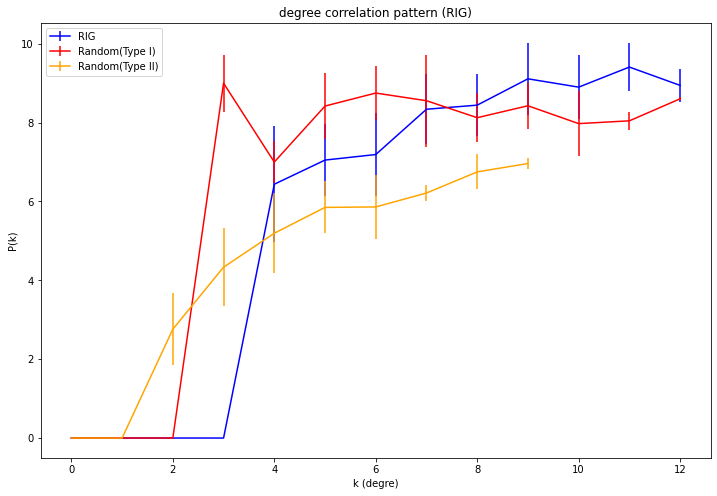

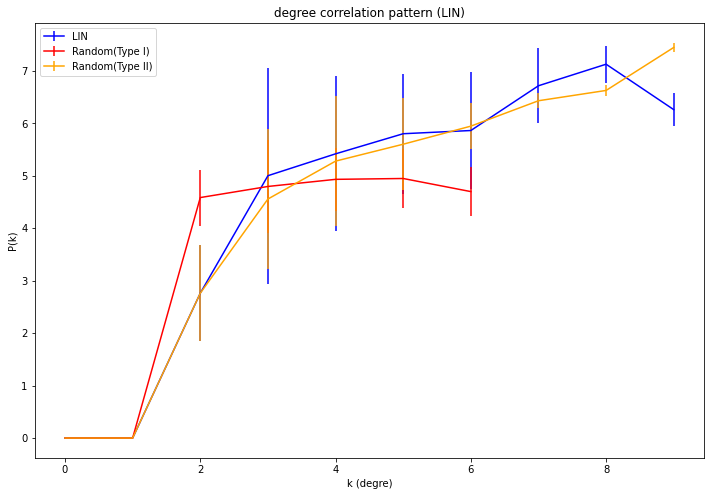

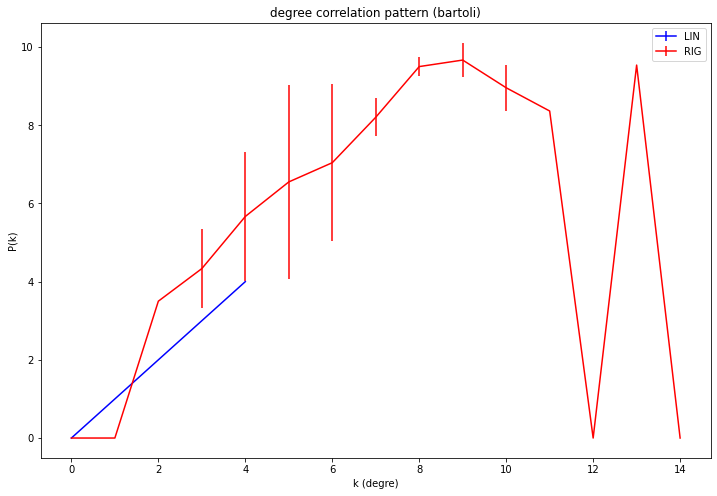

In [34]:
plt.errorbar(y = n_rig_kvsknn, x = np.arange(len(n_rig_kvsknn)), yerr=ns_rig_kvsknn, color="blue",label="RIG")
plt.errorbar(y = n_rig_r1_kvsknn, x = np.arange(len(n_rig_r1_kvsknn)), yerr=ns_rig_r1_kvsknn, color="red",label="Random(Type I)")
plt.errorbar(y = n_rig_r2_kvsknn, x = np.arange(len(n_rig_r2_kvsknn)), yerr=ns_rig_r2_kvsknn, color="orange",label="Random(Type II)")
plt.xlabel("k (degre)")
plt.ylabel("P(k)")
plt.title("degree correlation pattern (RIG)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/RIG_degree_correlation2')
plt.show()

plt.errorbar(y = n_lin_kvsknn, x = np.arange(len(n_lin_kvsknn)), yerr=ns_lin_kvsknn, color="blue", label="LIN")
plt.errorbar(y = n_lin_r1_kvsknn, x = np.arange(len(n_lin_r1_kvsknn)), yerr=ns_lin_r1_kvsknn, color="red", label="Random(Type I)")
plt.errorbar(y = n_lin_r2_kvsknn, x = np.arange(len(n_lin_r2_kvsknn)), yerr=ns_lin_r2_kvsknn, color="orange",label="Random(Type II)")
plt.xlabel("k (degre)")
plt.ylabel("P(k)")
plt.title("degree correlation pattern (LIN)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LIN_degree_correlation2')
plt.show()


plt.errorbar(y = n_bartoli_lin_kvsknn, x = np.arange(len(n_bartoli_lin_kvsknn)), yerr=ns_bartoli_lin_kvsknn, color="blue", label="LIN")
plt.errorbar(y = n_bartoli_kvsknn, x = np.arange(len(n_bartoli_kvsknn)), yerr=ns_bartoli_kvsknn, color="red", label="RIG")
plt.xlabel("k (degre)")
plt.ylabel("P(k)")
plt.title("degree correlation pattern (bartoli)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/bartoli_degree_correlation2')
plt.show()


# Correlation Coefficient

In [9]:
rig_corr = np.array(df["rig_pearson_correlation"])
rig_r1_corr = np.array(df["rig_r1_pearson_correlation"])
rig_r2_corr = np.array(df["rig_r2_pearson_correlation"])
lin_corr = np.array(df["lin_pearson_correlation"])
lin_r1_corr = np.array(df["lin_r1_pearson_correlation"])
lin_r2_corr = np.array(df["lin_r2_pearson_correlation"])

bartoli_corr = np.array(df["bartoli_pearson_correlation"])
lin_bartoli_corr = np.array(df["lin_bartoli_pearson_correlation"])

In [10]:
rig_corr = [i for i in rig_corr if i==i]
rig_r1_corr = [i for i in rig_r1_corr if i==i]
rig_r2_corr = [i for i in rig_r2_corr if i==i]
lin_corr = [i for i in lin_corr if i==i]
lin_r1_corr = [i for i in lin_r1_corr if i==i]
lin_r2_corr = [i for i in lin_r2_corr if i==i]
bartoli_corr = [i for i in bartoli_corr if i==i]
lin_bartoli_corr = [i for i in lin_bartoli_corr if i==i]

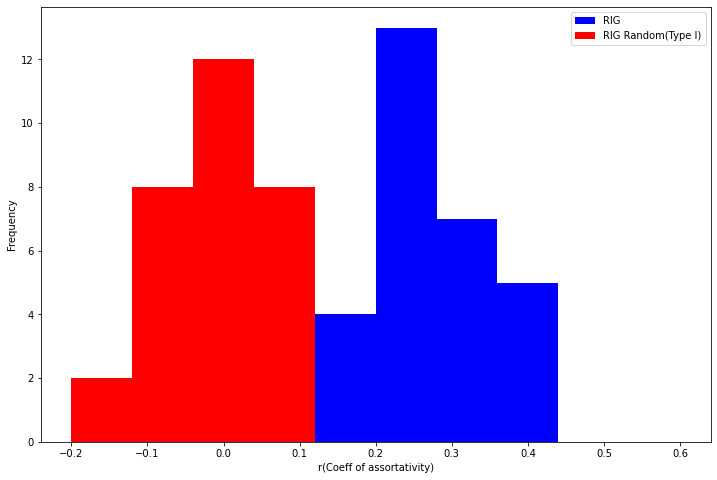

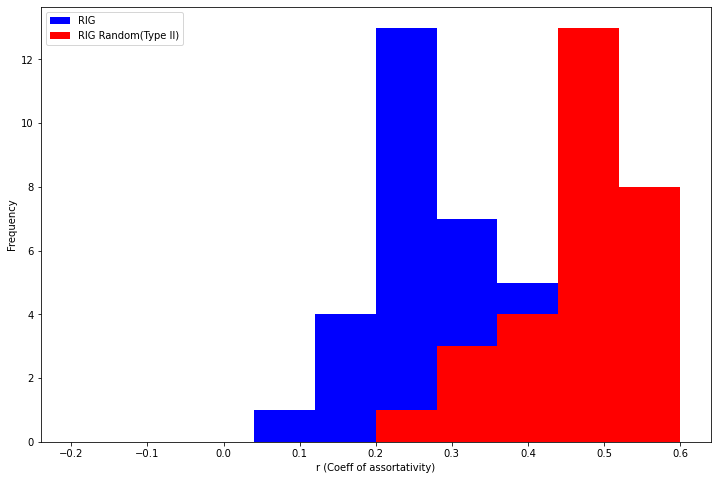

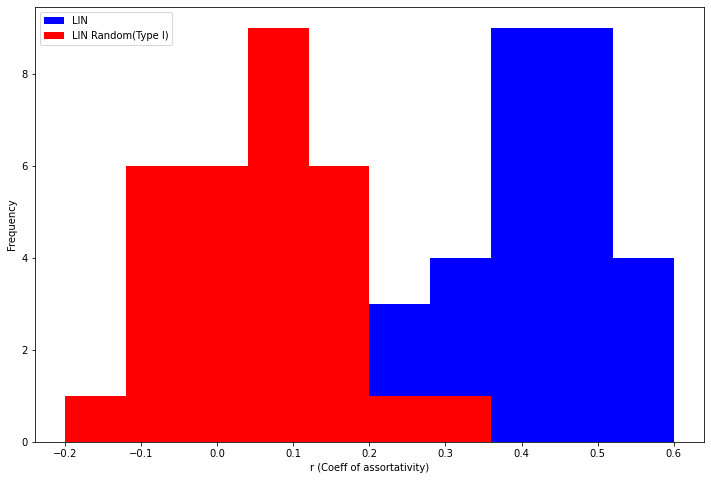

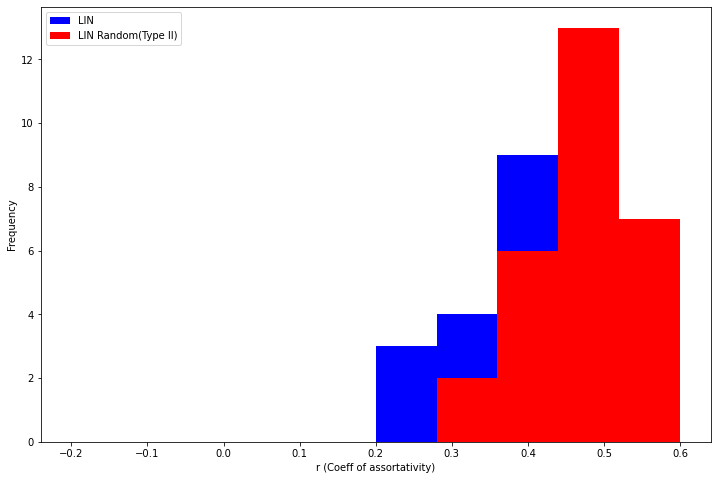

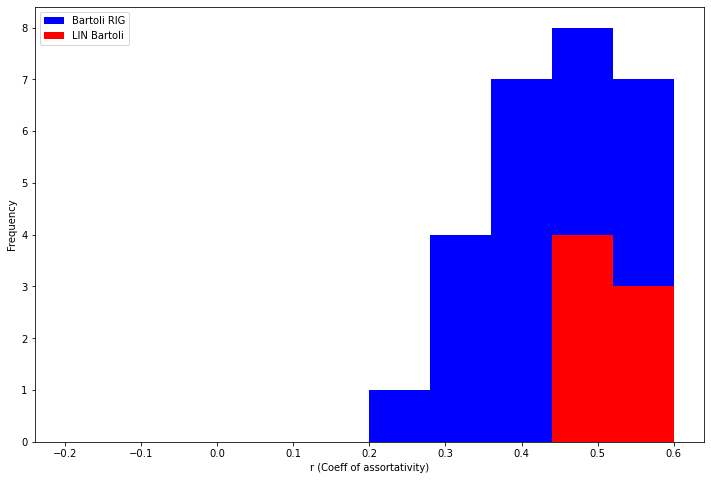

In [11]:
plt.hist(rig_corr, range = (-0.2,0.6),color="blue",label="RIG")
plt.hist(rig_r1_corr,range = (-0.2,0.6), color="red",label="RIG Random(Type I)")
plt.legend()
plt.xlabel("r(Coeff of assortativity)")
plt.ylabel("Frequency")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/RIGvsR1assort')
plt.show()

plt.hist(rig_corr, range = (-0.2,0.6),color="blue",label="RIG")
plt.hist(rig_r2_corr, range = (-0.2,0.6), color="red",label="RIG Random(Type II)")
plt.legend()
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("Frequency")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/RIGvsR2assort')
plt.show()

plt.hist(lin_corr, range = (-0.2,0.6), color="blue",label="LIN")
plt.hist(lin_r1_corr, range = (-0.2,0.6), color="red",label="LIN Random(Type I)")
plt.legend()
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("Frequency")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LINvsR1assort')
plt.show()

plt.hist(lin_corr, range = (-0.2,0.6),color="blue",label="LIN")
plt.hist(lin_r2_corr, range = (-0.2,0.6), color="red",label="LIN Random(Type II)")
plt.legend()
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("Frequency")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LINvsR2assort')
plt.show()

plt.hist(bartoli_corr, range = (-0.2,0.6),color="blue",label="Bartoli RIG")
plt.hist(lin_bartoli_corr, range = (-0.2,0.6), color="red",label="LIN Bartoli")
plt.legend()
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("Frequency")
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/Bartoli_RIG_LIN_correlation')
plt.show()

# C*kmax vs ln(kf)

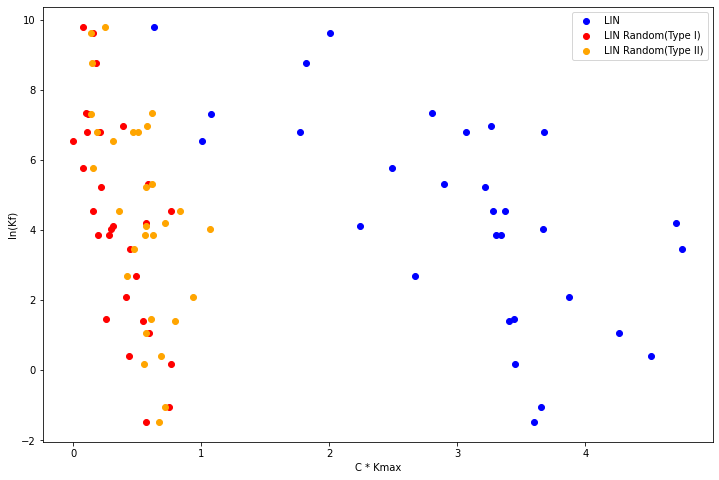

In [27]:
y = np.array(df["lnkf"])
x = np.array(df["lin_C"])*np.array(df["lin_deg_dist_max"])
plt.scatter(x,y,color="blue",label="LIN")
x = np.array(df["lin_r1_C"])*np.array(df["lin_r1_deg_dist_max"])
plt.scatter(x,y,color="red",label="LIN Random(Type I)")
x = np.array(df["lin_r2_C"])*np.array(df["lin_r2_deg_dist_max"])
plt.scatter(x,y,color="orange",label="LIN Random(Type II)")
plt.xlabel("C * Kmax")
plt.ylabel("ln(Kf)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LNKFvsC')
plt.show()


In [124]:
for i in range(len(df["rig_deg_dist"])):
#     df["rig_deg_dist"][i] = max(df["rig_deg_dist"][i])
    try:
        df["rig_r1_deg_dist"][i] = max(df["rig_r1_deg_dist"][i])
    except:
        continue
#     df["rig_r2_deg_dist"][i] = max(df["rig_r2_deg_dist"][i])
    

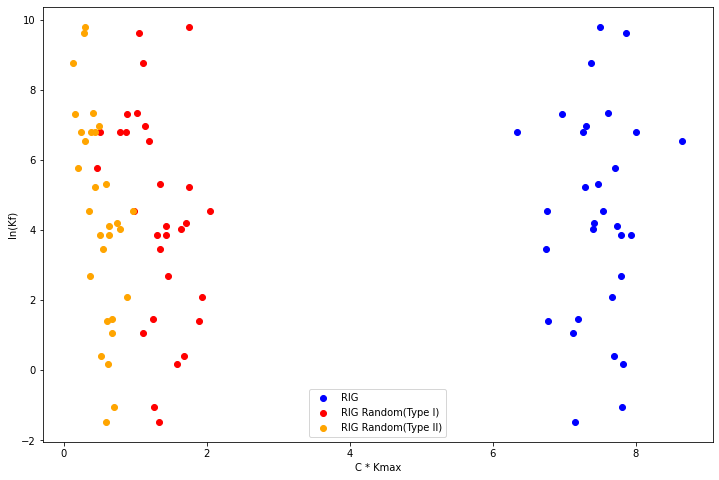

In [126]:
y = np.array(df["lnkf"])
x = np.array(df["rig_C"])*np.array(df["rig_deg_dist"])
plt.scatter(x,y,color="blue",label="RIG")
x = np.array(df["rig_r1_C"])*np.array(df["rig_r1_deg_dist"])
plt.scatter(x,y,color="red",label="RIG Random(Type I)")
x = np.array(df["rig_r2_C"])*np.array(df["rig_r2_deg_dist"])
plt.scatter(x,y,color="orange",label="RIG Random(Type II)")
plt.xlabel("C * Kmax")
plt.ylabel("ln(Kf)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LNKFvsCrig')
plt.show()


# r vs ln(kf)

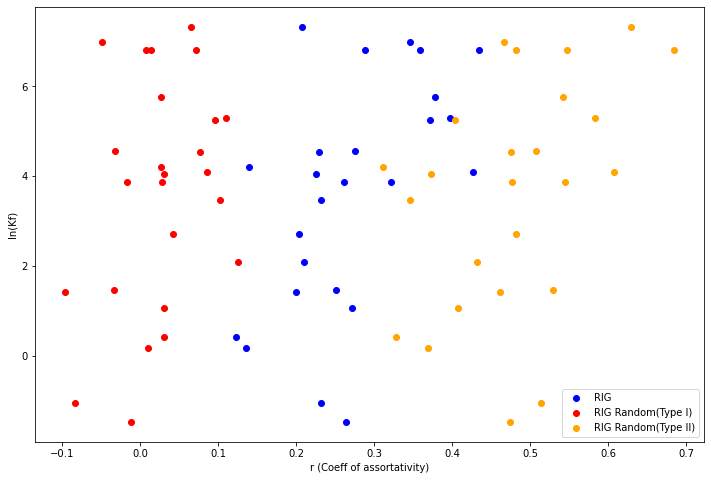

In [142]:
y = np.array(df["lnkf"])
x = np.array(df["rig_pearson_correlation"])
plt.scatter(x,y,color="blue",label="RIG")
x = np.array(df["rig_r1_pearson_correlation"])
plt.scatter(x,y,color="red",label="RIG Random(Type I)")
x = np.array(df["rig_r2_pearson_correlation"])
plt.scatter(x,y,color="orange",label="RIG Random(Type II)")
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("ln(Kf)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LNKFvsr')
plt.show()

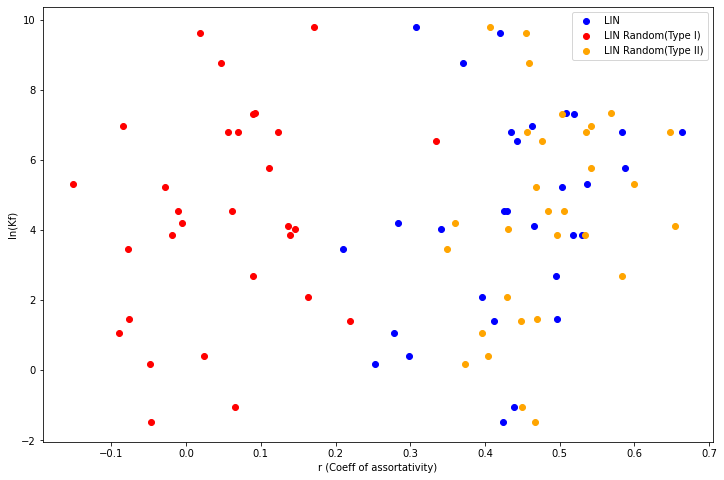

In [4]:
y = np.array(df["lnkf"])
x = np.array(df["lin_pearson_correlation"])
plt.scatter(x,y,color="blue",label="LIN")
x = np.array(df["lin_r1_pearson_correlation"])
plt.scatter(x,y,color="red",label="LIN Random(Type I)")
x = np.array(df["lin_r2_pearson_correlation"])
plt.scatter(x,y,color="orange",label="LIN Random(Type II)")
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("ln(Kf)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LNKFvsrLIN')
plt.show()

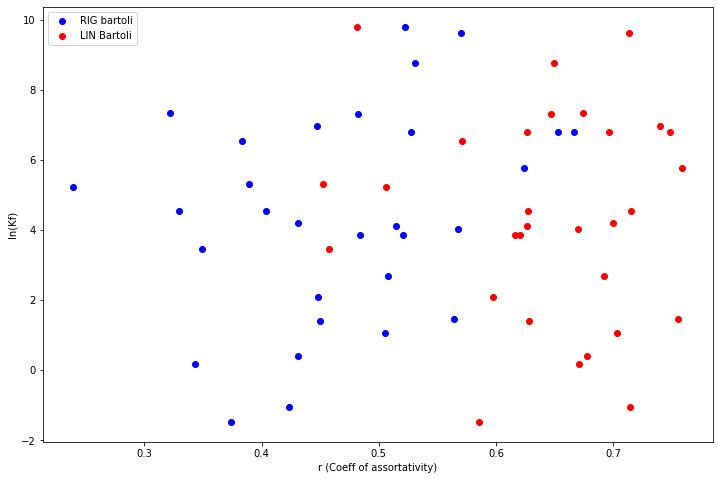

In [8]:
y = np.array(df["lnkf"])
x = np.array(df["bartoli_pearson_correlation"])
plt.scatter(x,y,color="blue",label="RIG bartoli")
x = np.array(df["lin_bartoli_pearson_correlation"])
plt.scatter(x,y,color="red",label="LIN Bartoli")
plt.xlabel("r (Coeff of assortativity)")
plt.ylabel("ln(Kf)")
plt.legend()
figure = plt.gcf()
figure.set_size_inches(12, 8)
plt.savefig('plots/LNKFvsrbartoli')
plt.show()